In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [4]:
tf.random.set_seed(69)
random.seed(69)
np.random.seed(69)
os.environ["PYTHONHASHSEED"] = str(69)

In [50]:
df = pd.read_csv('./data/dailySentiment.csv')
df.head()

,Unnamed: 0,Day,Price,Sentiment
0,4507,20150105,3.22,-0.534077
1,4508,20150106,2.98,-0.337025
2,4509,20150107,3.08,-0.065357
3,4510,20150108,2.92,-0.326590
4,4511,20150109,2.96,-0.374404


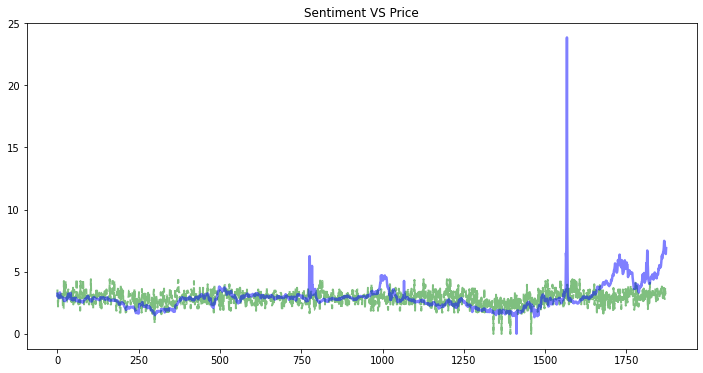

In [6]:
avg = sum(list(df.Price))/len(list(df.Price))
sen = list(df.Sentiment)
price = list(df.Price)
for i in range (len(sen)):
    sen[i] = -(sen[i]*avg)+2
plt.figure(figsize=(12, 6))
l1 = plt.plot(sen, lw = 2, color='green', alpha=0.5, linestyle='dashed')
l2 = plt.plot(price, lw = 2.5, color='blue', alpha=0.5)
plt.title('Sentiment VS Price')
plt.show()

In [7]:
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df)-window):
        res = []
        for j in range(0, window):
            res.append([df.Price[i+j], df.Sentiment[i+j]])
        res.append([0, df.Sentiment[i+window]])
        xRes.append(res)
        yRes.append(df.Price[i+window])
    tf.convert_to_tensor(xRes)
    return (tf.convert_to_tensor(xRes), tf.convert_to_tensor(yRes))

In [8]:
SPLIT = 0.85
xVal, yVal = singleStepSampler(df, 20)
xTrain = xVal[:int(SPLIT*len(xVal))]
yTrain = yVal[:int(SPLIT*len(yVal))]
xTest = xVal[int(SPLIT*len(xVal)):]
yTest = yVal[int(SPLIT*len(yVal)):]
(xTrain.shape, xTest.shape)

(TensorShape([1575, 21, 2]), TensorShape([278, 21, 2]))

In [45]:
(xTrain[0], yTrain[0])

(<tf.Tensor: shape=(21, 2), dtype=float64, numpy=
 array([[ 2.7       , -0.4448338 ],
        [ 2.87      , -0.17962492],
        [ 2.86      , -0.52417843],
        [ 2.79      , -0.32171516],
        [ 2.72      , -0.124277  ],
        [ 2.67      , -0.76904183],
        [ 2.62      , -0.47305674],
        [ 2.62      , -0.47305674],
        [ 2.7       , -0.4448338 ],
        [ 2.65      , -0.8192868 ],
        [ 2.58      , -0.32072873],
        [ 2.5       , -0.29020108],
        [ 2.6       , -0.37207218],
        [ 2.45      , -0.66663613],
        [ 2.53      , -0.46290142],
        [ 2.55      , -0.79966372],
        [ 2.56      , -0.54804678],
        [ 2.56      , -0.54804678],
        [ 2.52      , -0.49545295],
        [ 2.52      , -0.49545295],
        [ 0.        , -0.32072873]])>,
 <tf.Tensor: shape=(21, 2), dtype=float64, numpy=
 array([[ 5.52      , -0.35035633],
        [ 5.32      , -0.47504389],
        [ 5.32      , -0.47504389],
        [ 5.46      , -0.36106903

In [10]:
def smape(y_true, y_pred):
    epsilon = 0.1
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / summ * 2.0
    return smape

In [84]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(32, kernel_size=(3), input_shape=(21, 2)))
model.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=(1), padding='valid'))
model.add(tf.keras.layers.LSTM(256, return_sequences=True))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae', smape])

In [87]:
model.fit(xTrain, yTrain, epochs=50)

Epoch 1/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0955 - mse: 0.1885 - mae: 0.0955 - smape: 0.0321
Epoch 2/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0985 - mse: 0.1889 - mae: 0.0985 - smape: 0.0334
Epoch 3/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0992 - mse: 0.1901 - mae: 0.0992 - smape: 0.0335
Epoch 4/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0963 - mse: 0.1943 - mae: 0.0963 - smape: 0.0325
Epoch 5/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0949 - mse: 0.1920 - mae: 0.0949 - smape: 0.0320
Epoch 6/50
50/50 [==============================] - 0s 8ms/step - loss: 0.1004 - mse: 0.1857 - mae: 0.1004 - smape: 0.0340
Epoch 7/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0944 - mse: 0.1872 - mae: 0.0944 - smape: 0.0318
Epoch 8/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1038 - mse: 0.1834 - mae: 0.1038 - smape: 0.0353
Epoch 9/50
50/5

In [32]:
model = tf.keras.models.load_model('./models/singleStepDailyProposed.h5', custom_objects={'smape': smape})

In [88]:
model.evaluate(xTest, yTest)

9/9 [==============================] - 0s 7ms/step - loss: 0.1669 - mse: 0.0641 - mae: 0.1669 - smape: 0.0352


[0.166855126619339,
 0.06414984911680222,
 0.166855126619339,
 0.03518914431333542]

In [62]:
data = []
for item in xTest:
    data.append(model.predict(np.array([item])))

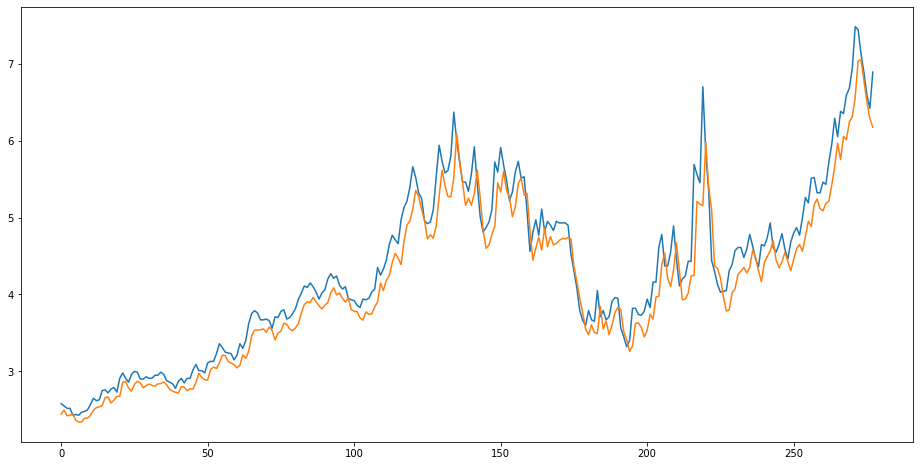

In [63]:
dafr = pd.DataFrame(data={'actual': yTest, 'prediction': [item[0][0] for item in data]})
plt.figure(figsize=(16, 8))
plt.plot(dafr)
plt.show()

In [149]:
model.save('./models/singleStepDailyProposed.h5')

In [ ]:
def multiStepSampler(df, window, door):
    xRes = []
    yRes = []
    for i in range(0, len(df)-window):
        res = []
        for j in range(0, window):
            res.append([df.Price[i+j], df.Sentiment[i+j]])
        res.append([0, df.Sentiment[i+window]])
        xRes.append(res)
        yRes.append(df.Price[i+window])
    tf.convert_to_tensor(xRes)
    return (tf.convert_to_tensor(xRes), tf.convert_to_tensor(yRes))

In [2]:
df = pd.read_csv('./data/weeklySentiment.csv')
df.head()

,Unnamed: 0,Day,Price,Sentiment
0,937,20150102,3.09,-0.302197
1,938,20150109,3.03,-0.315763
2,939,20150116,3.08,-0.062993
3,940,20150123,2.95,-0.287980
4,941,20150130,2.91,-0.445800


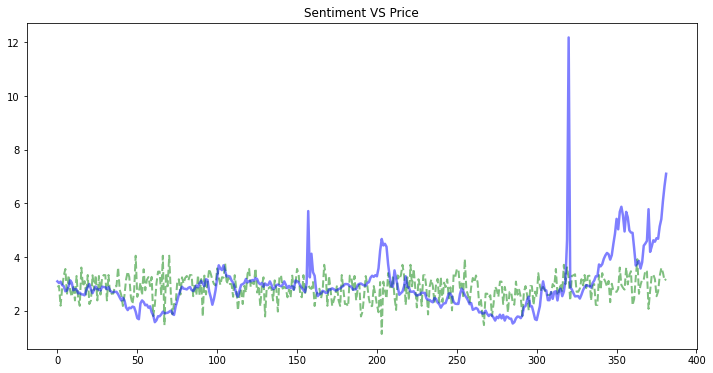

In [3]:
avg = sum(list(df.Price))/len(list(df.Price))
sen = list(df.Sentiment)
price = list(df.Price)
for i in range (len(sen)):
    sen[i] = -(sen[i]*avg)+2
plt.figure(figsize=(12, 6))
l1 = plt.plot(sen, lw = 2, color='green', alpha=0.5, linestyle='dashed')
l2 = plt.plot(price, lw = 2.5, color='blue', alpha=0.5)
plt.title('Sentiment VS Price')
plt.show()